久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第2章 確率分布と統計モデルの最尤推定

## 2.1 種子数の統計モデリング（p.14）

In [1]:
using Statistics
using Plots
pyplot();
using Printf
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


In [2]:
data = [
    2, 2, 4, 6, 4, 5, 2, 3, 1, 2,
    0, 4, 3, 3, 3, 3, 4, 2, 7, 2,
    4, 3, 3, 3, 4, 3, 7, 5, 3, 1,
    7, 6, 4, 6, 5, 2, 4, 7, 2, 2,
    6, 2, 4, 5, 4, 5, 1, 3, 2, 3];
length(data)

50

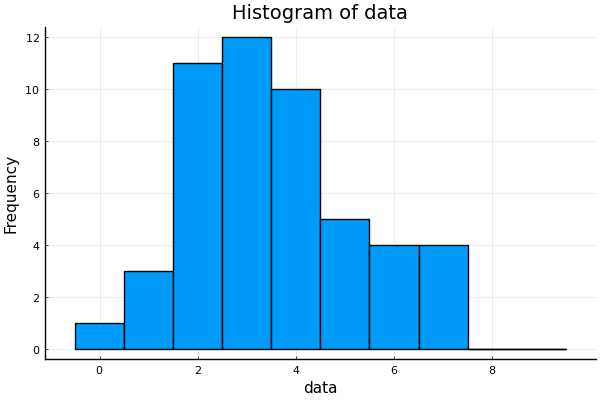

In [3]:
# ヒストグラム
histogram(data, bins=-0.5:9.5, xlabel="data", ylabel="Frequency", title="Histogram of data", xticks=0:2:8, yticks=0:2:12, legend=false)

In [4]:
# 標本分散（不偏分散, corrected=falseがデフォルトなので省略してもいい）
var(data, corrected=false)

2.9263999999999997

In [5]:
# 標本標準偏差
std(data)

1.728040060004279

## 2.2 データと確率分布の対応関係をながめる（p.18）

In [6]:
using Distributions

In [7]:
y = 0:9
prob = pdf.(Poisson(3.56), y)

10-element Array{Float64,1}:
 0.028438824714184505
 0.10124221598249684
 0.18021114444884437
 0.21385055807929534
 0.19032699669057287
 0.1355128216436879
 0.08040427417525477
 0.04089131658055819
 0.018196635878348365
 0.0071977804141022395

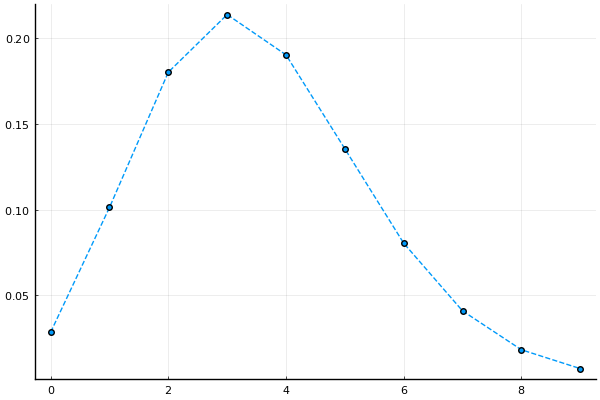

In [8]:
plot(y, prob, markershape=:auto, linestyle=:dash, legend=false)

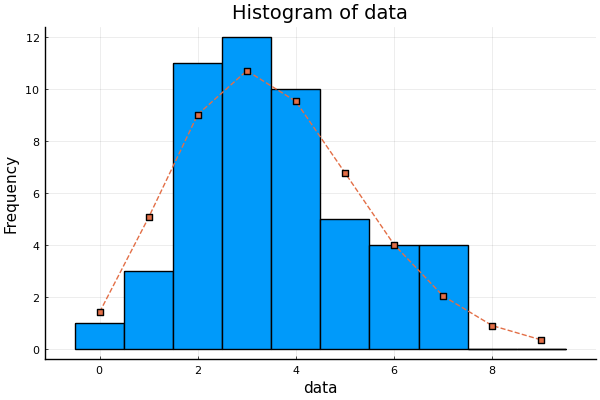

In [9]:
histogram(data, bins=-0.5:9.5, xlabel="data", ylabel="Frequency", title="Histogram of data", xticks=0:2:8, yticks=0:2:12, legend=false)
plot!(y, prob*50, markershape=:auto, linestyle=:dash)

## 2.3 ポアソン分布とは何か？（p.21）

$$ p\left(y|\lambda\right) = \frac{\lambda^y\exp\left(-\lambda\right)}{y!} $$

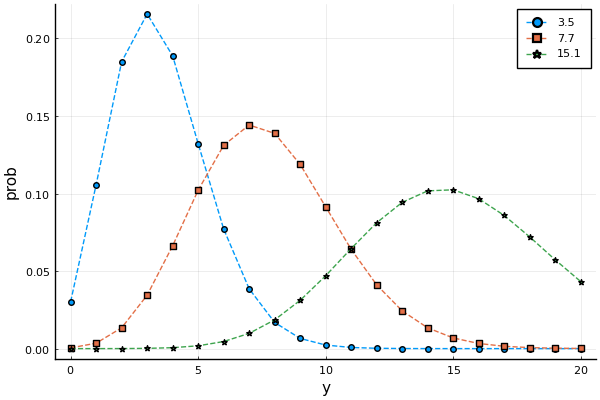

In [10]:
y = 0:20
plot(y, pdf.(Poisson(3.5), y), markershape=:auto, linestyle=:dash, xlabel="y", ylabel="prob", label="3.5")
plot!(y, pdf.(Poisson(7.7), y), markershape=:auto, linestyle=:dash, label="7.7")
plot!(y, pdf.(Poisson(15.1), y), markershape=:auto, linestyle=:dash, label="15.1")

## 2.4 ポアソン分布のパラメーターの最尤推定（p.24）

得られているデータ（観測値）からパラメータ（今回は$\lambda$）を推定する。**尤度**$L$は「得られたデータの事象がすべて同時に真である確率」なので、各データ$y_i$が得られる確率$p(y_i | \lambda)$の積になる。

$$ L\left(\lambda\right) = \prod_i p\left(y_i | \lambda\right) = \prod_i \frac{\lambda^{y_i}\exp\left(-\lambda\right)}{y_{i}!} $$

このままだと値が小さくなりすぎて精度が悪くなるなどいろいろ問題が。例えば以下では単純に積で計算しているけど、浮動小数点数の識別限界を下回っているので、値をそのまま信じていいのかどうかわからない。

In [11]:
# 例
prod(pdf.(Poisson(3.5), data))

5.706394934716174e-43

In [12]:
eps(Float64)   # Float64型で識別できる最小の差

2.220446049250313e-16

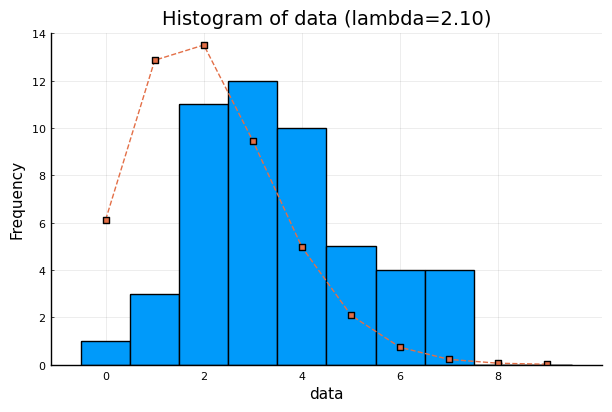

Plots.AnimatedGif("/Volumes/GoogleDrive/マイドライブ/_julia/kubo_midoribon/fig-2-7.gif")
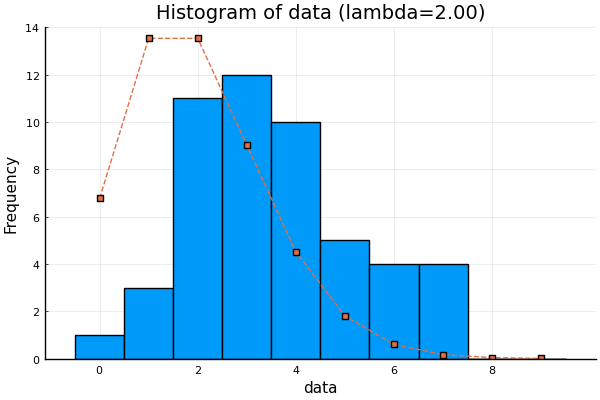

In [13]:
y = 0:9
anim = @animate for lambda = [2:0.05:5  ; 4.9:-0.05:2.1]
    histogram(data, bins=-0.5:9.5,
        xlabel="data", ylabel="Frequency", title=@sprintf("Histogram of data (lambda=%.2f)", lambda),
        xticks=0:2:8, yticks=0:2:14, ylim=(0,14), legend=false)
    prob = pdf.(Poisson(lambda), y)
    plot!(y, prob*50, markershape=:auto, linestyle=:dash)
end

using Suppressor   # suppress info message (which includes my local path names)
@suppress gif(anim, "fig-2-7.gif")

対数を使うと積を和にできるので計算が現実的になる。これを **対数尤度**（_log-likelihood_）と呼ぶ。

$$ \log_e L\left(\lambda\right) = \sum_i\left( \log_e p\left(y_i | \lambda\right) \right) = \sum_i\left( y_i\log_e\lambda - \lambda - \sum_k^{y_i}\log_e k \right) $$

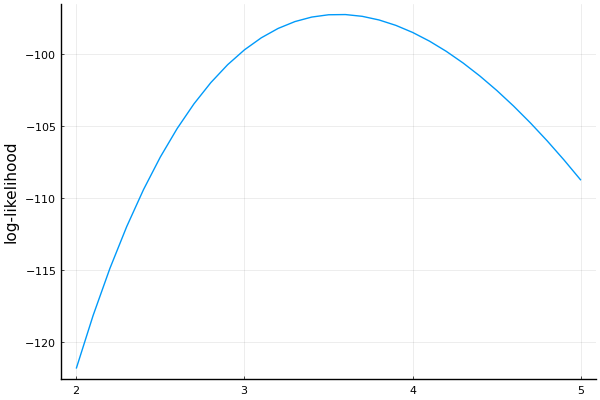

In [14]:
function logL(m, data)
    sum(log.(pdf.(Poisson(m), data)))
end

lambda = 2:0.1:5
plot(lambda, map(m -> logL(m, data), lambda), ylabel="log-likelihood", legend=false)

対数尤度関数$\log L\left(\lambda\right)$が最大になるところ（最ももっともらしい$\lambda$であるところ）を探す。微分して傾きがゼロになるところが極大・極小値なので、対数尤度関数を偏微分する。

$$ \frac{\partial\log L\left(\lambda\right)}{\partial\lambda} = \sum_i \left(\frac{y_i}{\lambda} - 1\right) = \frac{1}{\lambda}\sum_i y_i - 50$$

これがゼロになる$\hat{\lambda}$を**最尤推定値**（_maximum likelihood estimate_）と呼ぶ。今回のケースではデータの標本平均が最尤推定値である。

In [15]:
lambda_hat = mean(data)

3.56

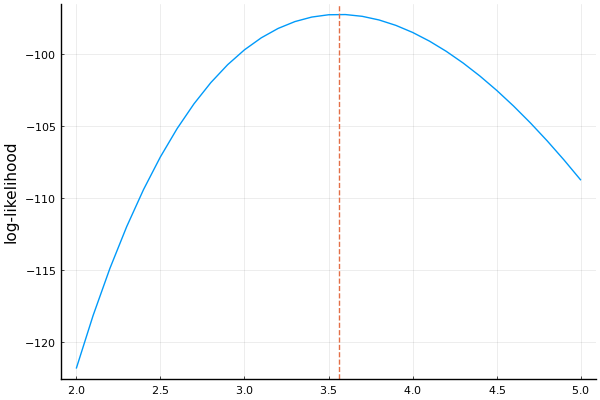

In [16]:
plot(lambda, map(m -> logL(m, data), lambda), ylabel="log-likelihood", legend=false, xticks=2.0:0.5:5.0)
vline!([lambda_hat], linestyle=:dash)

### 2.4.1 擬似乱数と最尤推定値のばらつき

In [17]:
rand(Poisson(3.5), 50)   # Rのrpoisに相当

50-element Array{Int64,1}:
 7
 1
 5
 3
 4
 4
 4
 5
 2
 3
 2
 4
 2
 5
 5
 3
 1
 0
 5
 3
 6
 2
 2
 4
 3
 4
 2
 3
 5
 2
 9
 6
 7
 2
 2
 3
 1
 5
 0
 6
 2
 4
 3
 2
 8
 2
 3
 2
 1
 4

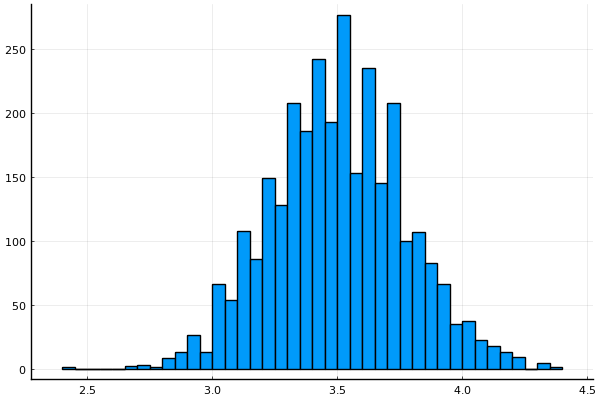

In [18]:
maxruns = 3000
lambda_hat = zeros(maxruns)
for n = 1:maxruns
    lambda_hat[n] = mean(rand(Poisson(3.5), 50))   # 最尤推定値は平均値
end
histogram(lambda_hat, legend=false)

この（何度も同じ試行を繰り返して得られた多くの）推定値のばらつきを**標準誤差**と呼ぶ。

僕は、まず標本分布のことを「（たとえば標本平均のような）サンプリングごとにぶれてしまう母数の推定値をたくさん集めたときの分布」と考えておいて、標準誤差は標本分布の標準偏差、と二段で考えている。